# Project : Conversion rate challenge

# Import libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix

!pip install plotly -q
!pip install -U kaleido -q
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
# setting Jedha color palette as default
pio.templates["jedha"] = go.layout.Template(
    layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
)
pio.templates.default = "jedha"
pio.renderers.default = "svg" # to be replaced by "iframe" if working on JULIE
from IPython.display import display

# Read file with labels

In [2]:
data = pd.read_csv('src/conversion_data_train.csv')
print('Set with labels (our train+test) :', data.shape)

Set with labels (our train+test) : (284580, 6)


In [3]:
data.head()

country  age  new_user  source  total_pages_visited  converted
0    China   22         1  Direct                    2          0
1       UK   21         1     Ads                    3          0
2  Germany   20         0     Seo                   14          1
3       US   23         1     Seo                    3          0
4       US   28         1  Direct                    3          0

In [4]:
# Shape of the dataset
data.shape

(284580, 6)

In [5]:
# Basic statistics
data.describe(include='all')

country            age       new_user  source  total_pages_visited  \
count   284580  284580.000000  284580.000000  284580        284580.000000   
unique       4            NaN            NaN       3                  NaN   
top         US            NaN            NaN     Seo                  NaN   
freq    160124            NaN            NaN  139477                  NaN   
mean       NaN      30.564203       0.685452     NaN             4.873252   
std        NaN       8.266789       0.464336     NaN             3.341995   
min        NaN      17.000000       0.000000     NaN             1.000000   
25%        NaN      24.000000       0.000000     NaN             2.000000   
50%        NaN      30.000000       1.000000     NaN             4.000000   
75%        NaN      36.000000       1.000000     NaN             7.000000   
max        NaN     123.000000       1.000000     NaN            29.000000   

            converted  
count   284580.000000  
unique            NaN  
top               NaN  
freq              NaN  
mean         0.032258  
std          0.176685  
min          0.000000  
25%          0.000000  
50%          0.000000  
75%          0.000000  
max          1.000000

In [6]:
# Explore values types for each column
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284580 entries, 0 to 284579
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   country              284580 non-null  object
 1   age                  284580 non-null  int64 
 2   new_user             284580 non-null  int64 
 3   source               284580 non-null  object
 4   total_pages_visited  284580 non-null  int64 
 5   converted            284580 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 13.0+ MB


In [7]:
# Percentage of missing values
display(100*data.isnull().sum()/data.shape[0])

country                0.0
age                    0.0
new_user               0.0
source                 0.0
total_pages_visited    0.0
converted              0.0
dtype: float64

# Explore dataset

In [8]:
# The dataset is quite big : you must create a sample of the dataset before making any visualizations !
data = data.sample(10000)

In [9]:
data.columns

Index(['country', 'age', 'new_user', 'source', 'total_pages_visited',
       'converted'],
      dtype='object')

In [10]:
dict_conv = { 0 : 'Non-converted',
              1 : 'Converted'}
dict_user = { 0 : 'Old user',
              1 : 'New user'}

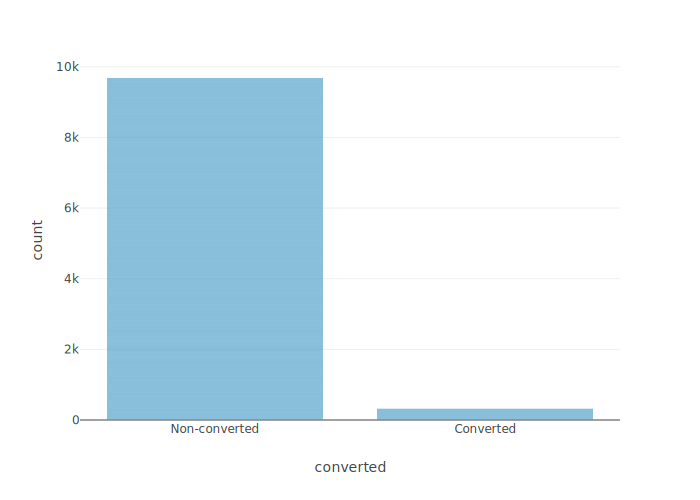

In [11]:
# Target distribution
fig = px.bar(data['converted'].map(dict_conv), 'converted')
fig.show()

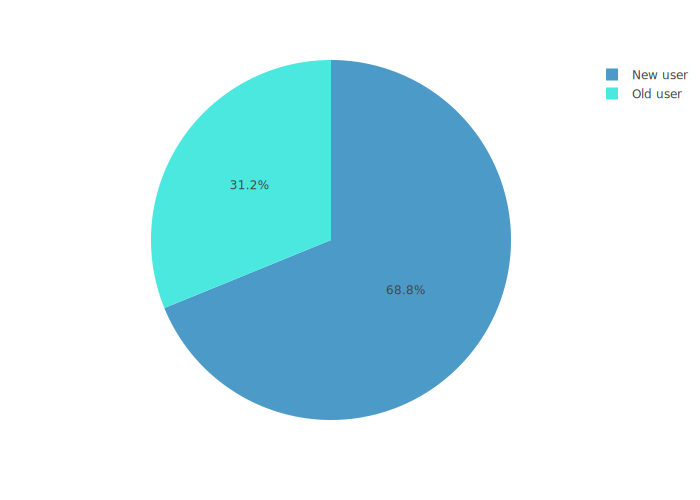

In [12]:
# User type distribution
fig = px.pie(data['new_user'].map(dict_user), 'new_user')
fig.show()

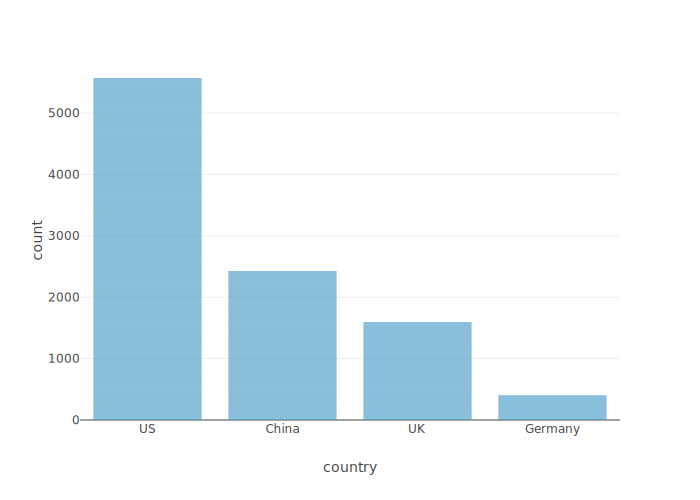

In [13]:
# Country distribution
fig = px.bar(data, 'country')
fig.show()

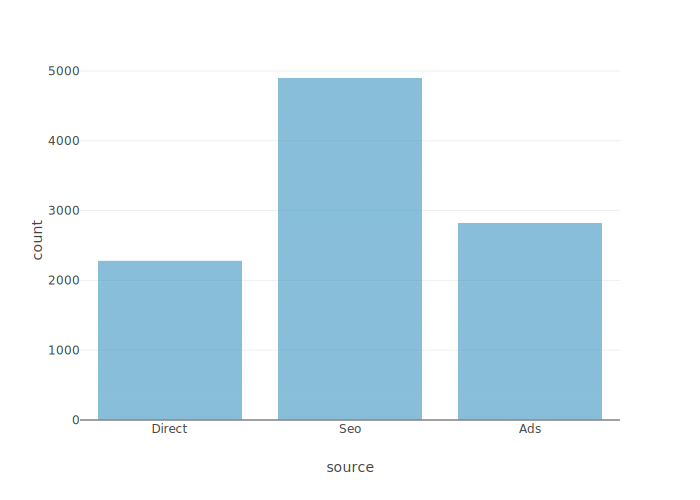

In [14]:
# Source distribution
fig = px.bar(data, 'source')
fig.show()

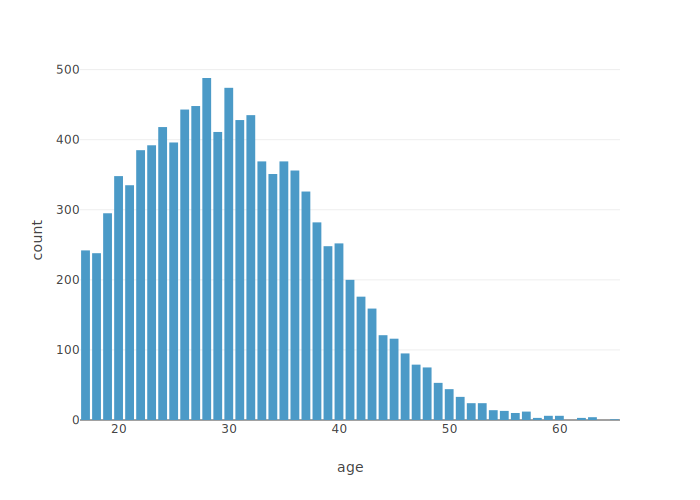

In [15]:
# Age distribution
fig = px.histogram(data, x='age')
fig.update_layout(bargap=0.2)
fig.show()

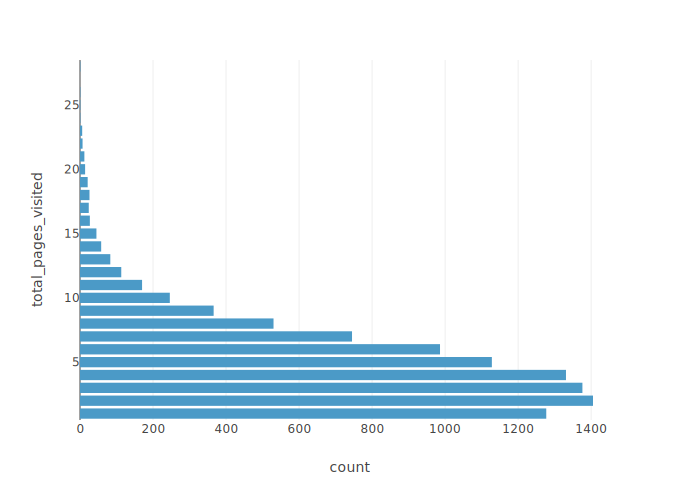

In [16]:
# Total_pages visited 
fig = px.histogram(data, y='total_pages_visited')
fig.update_layout(bargap=0.2)
fig.show()

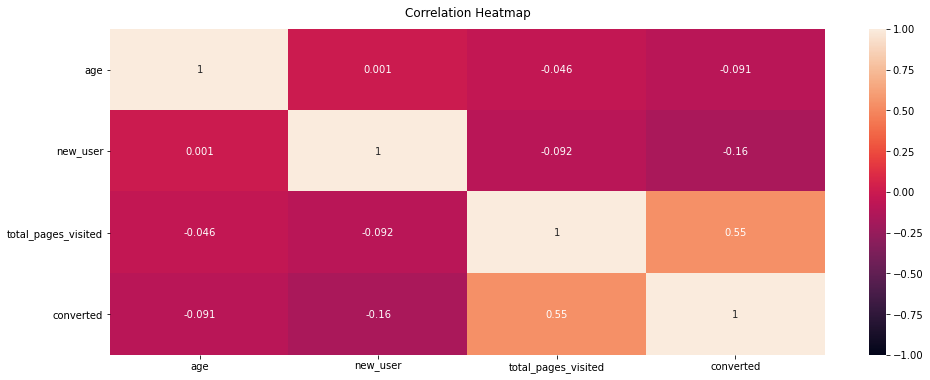

In [17]:
# Correlation matrix

plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(data.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

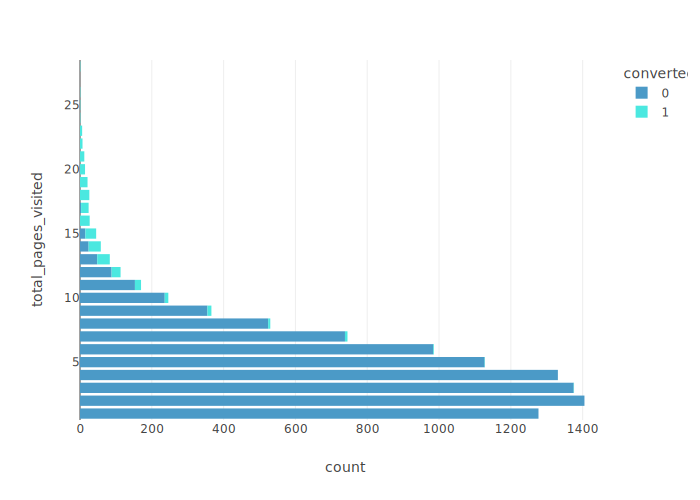

In [18]:
# Total_pages visited 
fig = px.histogram(data, y='total_pages_visited', color = 'converted')
fig.update_layout(bargap=0.2)
fig.show()

# Make your model

## Choose variables to use in the model, and create train and test sets
**From the EDA, we know that the most useful feature is total_pages_visited. Let's create a baseline model by using at first only this feature : in the next cells, we'll make preprocessings and train a simple (univariate) logistic regression.**

In [19]:
data.columns

Index(['country', 'age', 'new_user', 'source', 'total_pages_visited',
       'converted'],
      dtype='object')

In [20]:
features_list = ['total_pages_visited']
numeric_indices = [0]
categorical_indices = []
target_variable = 'converted'

In [21]:
X = data.loc[:, features_list]
Y = data.loc[:, target_variable]

print('Explanatory variables : ', X.columns)
print()

Explanatory variables :  Index(['total_pages_visited'], dtype='object')



In [22]:
# Divide dataset Train set & Test set 
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=0)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



In [23]:
# Convert pandas DataFrames to numpy arrays before using scikit-learn
print("Convert pandas DataFrames to numpy arrays...")
X_train = X_train.values
X_test = X_test.values
Y_train = Y_train.values
Y_test = Y_test.values
print("...Done")

print(X_train[0:5,:])
print(X_test[0:2,:])
print()
print(Y_train[0:5])
print(Y_test[0:2])

Convert pandas DataFrames to numpy arrays...
...Done
[[3]
 [9]
 [4]
 [4]
 [3]]
[[3]
 [7]]

[0 0 0 0 0]
[0 0]


## Training pipeline

In [24]:
# Put here all the preprocessings
print("Encoding categorical features and standardizing numerical features...")

featureencoder = StandardScaler()
X_train = featureencoder.fit_transform(X_train)
print("...Done")
print(X_train[0:5,:])

Encoding categorical features and standardizing numerical features...
...Done
[[-0.55728699]
 [ 1.22023797]
 [-0.26103283]
 [-0.26103283]
 [-0.55728699]]


In [25]:
# Train model
print("Train model...")
classifier = LogisticRegression() # 
classifier.fit(X_train, Y_train)
print("...Done.")

Train model...
...Done.


In [26]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = classifier.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]



## Test pipeline

In [27]:
# Use X_test, and the same preprocessings as in training pipeline, 
# but call "transform()" instead of "fit_transform" methods (see example below)

print("Encoding categorical features and standardizing numerical features...")

X_test = featureencoder.transform(X_test)
print("...Done")
print(X_test[0:5,:])

Encoding categorical features and standardizing numerical features...
...Done
[[-0.55728699]
 [ 0.62772965]
 [-1.14979531]
 [-0.26103283]
 [-0.55728699]]


In [28]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = classifier.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on test set...
...Done.
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

## Performance assessment

In [29]:
# WARNING : Use the same score as the one that will be used by Kaggle !
# Here, the f1-score will be used to assess the performances on the leaderboard
print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

f1-score on train set :  0.7218934911242603
f1-score on test set :  0.7037037037037037


In [30]:
# You can also check more performance metrics to better understand what your model is doing
print("Confusion matrix on train set : ")
print(confusion_matrix(Y_train, Y_train_pred))
print()
print("Confusion matrix on test set : ")
print(confusion_matrix(Y_test, Y_test_pred))
print()

Confusion matrix on train set : 
[[8676   36]
 [ 105  183]]

Confusion matrix on test set : 
[[965   6]
 [ 10  19]]



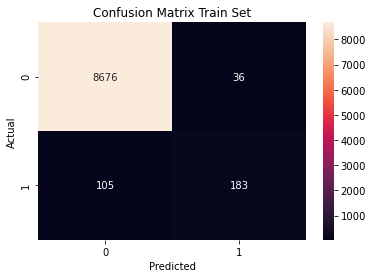

In [31]:
# Plot confusion matrix
actual_data = Y_train
predicted_data = Y_train_pred
cm = confusion_matrix(actual_data, predicted_data)
ax = sns.heatmap(cm, annot=True, fmt='g');
ax.set_title('Confusion Matrix Train Set');
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual');
plt.show()

**Our baseline model reaches a f1-score of almost 70%. Now, feel free to refine your model and try to beat this score ! 🚀🚀**

In [32]:
# Define a function that will make all the preprocessings
def preprocessings(data, features_list, numeric_indices, categorical_indices):
    X = data.loc[:, features_list]
    Y = data.loc[:, target_variable]

    # Divide dataset Train set & Test set 
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=0)

    # Convert pandas DataFrames to numpy arrays before using scikit-learn
    X_train = X_train.values
    X_test = X_test.values
    Y_train = Y_train.values
    Y_test = Y_test.values

    # Encoding categorical features and standardizing numerical features
    ## Create pipeline for numeric features
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')), # missing values in Age will be replaced by columns' mean
        ('scaler', StandardScaler())
    ])

    ## Create pipeline for categorical features
    categorical_transformer = Pipeline(
        steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')), # missing values will be replaced by most frequent value
        ('encoder', OneHotEncoder(drop='first')) # first column will be dropped to avoid creating correlations between features
        ])
    ## Use ColumnTranformer to make all preprocessings
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_indices),
            ('cat', categorical_transformer, categorical_indices)
        ])

    # Preprocessings on train set
    X_train = preprocessor.fit_transform(X_train)

    # Preprocessings on test set
    X_test = preprocessor.transform(X_test)
    return(X_train,X_test,Y_train,Y_test,preprocessor)    

In [33]:
# Define a function that trains models and returs performances
def model_perf(classifier,X_train,X_test,Y_train,Y_test):
    # Train model
    classifier.fit(X_train, Y_train)

    # Predictions on training set
    Y_train_pred = classifier.predict(X_train)

    # Predictions on test set
    Y_test_pred = classifier.predict(X_test)
    
    # Confusion matrix
    cma= confusion_matrix(Y_test, Y_test_pred)
    # cma = cma/cma.astype(np.float).sum(axis=1)

    return(f1_score(Y_train, Y_train_pred), f1_score(Y_test, Y_test_pred), cma)

### Baseline : Univarite logistic resgression

In [34]:
features_list = ['total_pages_visited']
numeric_indices = [0]
categorical_indices = []
target_variable = 'converted'
classifier = LogisticRegression()
(X_train,X_test,Y_train,Y_test, preprocessor) = preprocessings(data, features_list, numeric_indices, categorical_indices)
baseline = model_perf(classifier,X_train,X_test,Y_train,Y_test)

In [35]:
print('F1-score on the train set for the baseline = {}'.format(baseline[0]))
print('F1-score on the test set for the baseline = {}'.format(baseline[1]))

F1-score on the train set for the baseline = 0.7218934911242603
F1-score on the test set for the baseline = 0.7037037037037037


### Multivariate logistic regression

For now, we will perform logistic regression by adding new features one by one

In [36]:
# Add country to the features
features_list = ['total_pages_visited','country']
numeric_indices = [0]
categorical_indices = [1]
target_variable = 'converted'
classifier = LogisticRegression()
(X_train,X_test,Y_train,Y_test, preprocessor) = preprocessings(data, features_list, numeric_indices, categorical_indices)
LR1  = model_perf(classifier,X_train,X_test,Y_train,Y_test)

In [37]:
print('F1-score on the train set for LR1 = {}'.format(LR1[0]))
print('F1-score on the test set for LR1 = {}'.format(LR1[1]))

F1-score on the train set for LR1 = 0.736
F1-score on the test set for LR1 = 0.7407407407407408


In [38]:
# Add age to the features
features_list = ['total_pages_visited','country','age']
numeric_indices = [0,2]
categorical_indices = [1]
target_variable = 'converted'
classifier = LogisticRegression()
(X_train,X_test,Y_train,Y_test, preprocessor) = preprocessings(data, features_list, numeric_indices, categorical_indices)
LR2  = model_perf(classifier,X_train,X_test,Y_train,Y_test)

In [39]:
print('F1-score on the train set for LR2 = {}'.format(LR2[0]))
print('F1-score on the test set for LR2 = {}'.format(LR2[1]))

F1-score on the train set for LR2 = 0.7626459143968871
F1-score on the test set for LR2 = 0.7924528301886793


In [40]:
# Add type of user to the features
features_list = ['total_pages_visited','country','age','new_user']
numeric_indices = [0,2]
categorical_indices = [1,3]
target_variable = 'converted'
classifier = LogisticRegression()
(X_train,X_test,Y_train,Y_test, preprocessor) = preprocessings(data, features_list, numeric_indices, categorical_indices)
LR3  = model_perf(classifier,X_train,X_test,Y_train,Y_test)

In [41]:
print('F1-score on the train set for LR3 = {}'.format(LR3[0]))
print('F1-score on the test set for LR3 = {}'.format(LR3[1]))

F1-score on the train set for LR3 = 0.8
F1-score on the test set for LR3 = 0.8727272727272727


In [42]:
# Add the source to the features
features_list = ['total_pages_visited','country','age','new_user','source']
numeric_indices = [0,2]
categorical_indices = [1,3,4]
target_variable = 'converted'
classifier = LogisticRegression()
(X_train,X_test,Y_train,Y_test, preprocessor) = preprocessings(data, features_list, numeric_indices, categorical_indices)
LR4  = model_perf(classifier,X_train,X_test,Y_train,Y_test)

In [43]:
print('F1-score on the train set for LR4 = {}'.format(LR4[0]))
print('F1-score on the test set for LR4 = {}'.format(LR4[1]))

F1-score on the train set for LR4 = 0.8045977011494253
F1-score on the test set for LR4 = 0.8679245283018867


In [44]:
pd.DataFrame([LR1,LR2,LR3,LR4], columns = ['F1-score train', 'F1-score test', 'Confusion matrix'], 
             index = ['LR1', 'LR2', 'LR3', 'LR4']).sort_values('F1-score test',ascending=False)

F1-score train  F1-score test     Confusion matrix
LR3        0.800000       0.872727  [[969, 2], [5, 24]]
LR4        0.804598       0.867925  [[970, 1], [6, 23]]
LR2        0.762646       0.792453  [[968, 3], [8, 21]]
LR1        0.736000       0.740741  [[966, 5], [9, 20]]

In [45]:
# Best logistic regression
LR = LR3
print('F1-score on the train set for the best logistic regression model = {}'.format(LR[0]))
print('F1-score on the test set for the best logistic regression model = {}'.format(LR[1]))

F1-score on the train set for the best logistic regression model = 0.8
F1-score on the test set for the best logistic regression model = 0.8727272727272727


### Decision Tree

In [46]:
features_list = ['total_pages_visited','country','age','new_user']
numeric_indices = [0,2]
categorical_indices = [1,3]
target_variable = 'converted'
classifier =  DecisionTreeClassifier()
(X_train,X_test,Y_train,Y_test, preprocessor) = preprocessings(data, features_list, numeric_indices, categorical_indices)
DT  = model_perf(classifier,X_train,X_test,Y_train,Y_test)

In [47]:
print('F1-score on the train set for the best logistic regression model = {}'.format(DT[0]))
print('F1-score on the test set for the best logistic regression model = {}'.format(DT[1]))

F1-score on the train set for the best logistic regression model = 0.9011406844106465
F1-score on the test set for the best logistic regression model = 0.8


### Random Forest

In [48]:
features_list = ['total_pages_visited','country','age','new_user']
numeric_indices = [0,2]
categorical_indices = [1,3]
target_variable = 'converted'
classifier =  RandomForestClassifier()
(X_train,X_test,Y_train,Y_test, preprocessor) = preprocessings(data, features_list, numeric_indices, categorical_indices)
RF  = model_perf(classifier,X_train,X_test,Y_train,Y_test)

In [49]:
print('F1-score on the train set for RF = {}'.format(RF[0]))
print('F1-score on the test set for RF = {}'.format(RF[1]))

F1-score on the train set for RF = 0.9022556390977444
F1-score on the test set for RF = 0.8148148148148148


### Models performances summary

In [50]:
scores = pd.DataFrame([baseline,LR,DT,RF], columns = ['F1-score train', 'F1-score test', 'Confusion matrix'], 
             index =  ['Baseline', 'Logistic Regression', 'Decision Tree', 'Random Forest']).sort_values('F1-score test',ascending=False)
scores

F1-score train  F1-score test      Confusion matrix
Logistic Regression        0.800000       0.872727   [[969, 2], [5, 24]]
Random Forest              0.902256       0.814815   [[968, 3], [7, 22]]
Decision Tree              0.901141       0.800000   [[967, 4], [7, 22]]
Baseline                   0.721893       0.703704  [[965, 6], [10, 19]]

The best model is the Random Forest

# Train best classifier on all data and use it to make predictions on X_without_labels
**Before making predictions on the file conversion_data_test.csv, let's train our model on ALL the data that was in conversion_data_train.csv. Sometimes, this allows to make tiny improvements in the score because we're using more examples to train the model.**

In [58]:
data = pd.read_csv('src/conversion_data_train.csv')

In [59]:
features_list = ['total_pages_visited','country','age','new_user']
numeric_indices = [0,2]
categorical_indices = [1,3]
target_variable = 'converted'
(X_train,X_test,Y_train,Y_test,preprocessor) = preprocessings(data, features_list, numeric_indices, categorical_indices)

In [60]:
# Concatenate our train and test set to train your best classifier on all data with labels
X = np.append(X_train,X_test,axis=0)
Y = np.append(Y_train,Y_test)

In [61]:
# Verify shapes
len(X_train) + len(X_test) == len(X) and len(Y_train) + len(Y_test) == len(Y)

True

In [62]:
classifier =  RandomForestClassifier()
classifier.fit(X,Y)

RandomForestClassifier()

In [63]:
# Read data without labels
data_without_labels = pd.read_csv('src/conversion_data_test.csv')
X_without_labels = data_without_labels.loc[:, features_list]

# Convert pandas DataFrames to numpy arrays before using scikit-learn
X_without_labels = X_without_labels.values

print(X_without_labels[0:5,:])

[[16 'UK' 28 0]
 [5 'UK' 22 1]
 [1 'China' 32 1]
 [6 'US' 32 1]
 [3 'China' 25 0]]


In [64]:
# WARNING : PUT HERE THE SAME PREPROCESSING AS FOR YOUR TEST SET
# CHECK YOU ARE USING X_without_labels
print("Encoding categorical features and standardizing numerical features...")

X_without_labels = preprocessor.transform(X_without_labels)
print("...Done")
print(X_without_labels[0:5,:])

Encoding categorical features and standardizing numerical features...
...Done
[[ 3.33326238 -0.31028053  0.          1.          0.          0.        ]
 [ 0.03879562 -1.03613923  0.          1.          0.          1.        ]
 [-1.15919229  0.17362526  0.          0.          0.          1.        ]
 [ 0.3382926   0.17362526  0.          0.          1.          1.        ]
 [-0.56019834 -0.67320988  0.          0.          0.          0.        ]]


In [65]:
len(X_without_labels)

31620

In [67]:
# Make predictions and dump to file

data = {
    'converted': classifier.predict(X_without_labels)
}

Y_predictions = pd.DataFrame(columns=['converted'],data=data)
Y_predictions.to_csv('src/conversion_data_test_predictions.csv', index=False)